In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv("../.env")

model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

# embedding = HuggingFaceEmbeddings(
#             model_name="../../Embedding/maidalun/bce-embedding-base_v1",
#             model_kwargs={"device": "cuda",
#                           "trust_remote_code": True},
#             encode_kwargs={"normalize_embeddings": True},
#         )

# Define subgraphs

In [2]:
from typing import Optional, Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END


# The structure of the logs
class Logs(TypedDict):
    id: str
    question: str
    answer: str
    grade: Optional[int]
    feedback: Optional[str]


# Define custom reducer (see more on this in the "Custom reducer" section below)
def add_logs(left: list[Logs], right: list[Logs]) -> list[Logs]:
    if not left:
        left = []

    if not right:
        right = []

    logs = left.copy()
    left_id_to_idx = {log["id"]: idx for idx, log in enumerate(logs)}
    # update if the new logs are already in the state, otherwise append
    for log in right:
        idx = left_id_to_idx.get(log["id"])
        if idx is not None:
            logs[idx] = log
        else:
            logs.append(log)
    return logs


# Failure Analysis Subgraph
class FailureAnalysisState(TypedDict):
    # keys shared with the parent graph (EntryGraphState)
    logs: Annotated[list[Logs], add_logs]
    failure_report: str
    # subgraph key
    failures: list[Logs]


def get_failures(state: FailureAnalysisState):
    failures = [log for log in state["logs"] if log["grade"] == 0]
    return {"failures": failures}


def generate_summary(state: FailureAnalysisState):
    failures = state["failures"]
    # NOTE: you can implement custom summarization logic here
    failure_ids = [log["id"] for log in failures]
    fa_summary = f"Poor quality of retrieval for document IDs: {', '.join(failure_ids)}"
    return {"failure_report": fa_summary}


fa_builder = StateGraph(FailureAnalysisState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)


# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    # keys that are shared with the parent graph (EntryGraphState)
    summary_report: str
    logs: Annotated[list[Logs], add_logs]
    # subgraph keys
    summary: str


def generate_summary(state: QuestionSummarizationState):
    docs = state["logs"]
    # NOTE: you can implement custom summarization logic here
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"summary": summary}


def send_to_slack(state: QuestionSummarizationState):
    summary = state["summary"]
    # NOTE: you can implement custom logic here, for example sending the summary generated in the previous step to Slack
    return {"summary_report": summary}


qs_builder = StateGraph(QuestionSummarizationState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

# Define parent graph

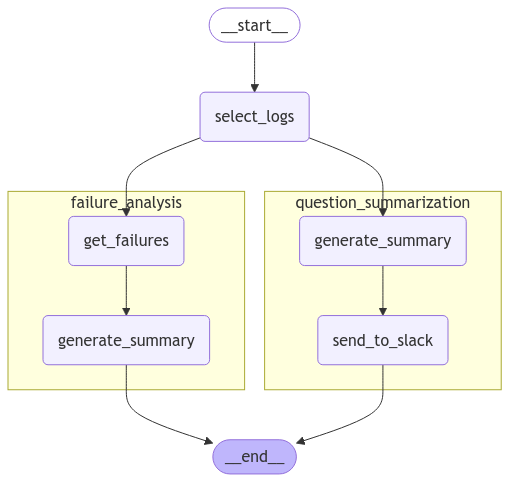

In [3]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: Annotated[list[Logs], add_logs]
    logs: Annotated[list[Logs], add_logs]  # This will be used in subgraphs
    failure_report: str  # This will be generated in the FA subgraph
    summary_report: str  # This will be generated in the QS subgraph


def select_logs(state):
    return {"logs": [log for log in state["raw_logs"] if "grade" in log]}


entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("select_logs", select_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "select_logs")
entry_builder.add_edge("select_logs", "failure_analysis")
entry_builder.add_edge("select_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

# Stream

## Define input

In [4]:
# Dummy logs
dummy_logs = [
    Logs(
        id="1",
        question="How can I import ChatOllama?",
        grade=1,
        answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
    ),
    Logs(
        id="2",
        question="How can I use Chroma vector store?",
        answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
        grade=0,
        feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
    ),
    Logs(
        id="3",
        question="How do I create react agent in langgraph?",
        answer="from langgraph.prebuilt import create_react_agent",
    ),
]

input = {"raw_logs": dummy_logs}

## Stream normally

In [5]:
for chunk in graph.stream(input, stream_mode="updates"):
    node_name = list(chunk.keys())[0]
    print(f"---------- Update from node {node_name} ---------")
    print(chunk[node_name])

---------- Update from node select_logs ---------
{'logs': [{'id': '1', 'question': 'How can I import ChatOllama?', 'grade': 1, 'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"}, {'id': '2', 'question': 'How can I use Chroma vector store?', 'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).', 'grade': 0, 'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}]}
---------- Update from node question_summarization ---------
{'summary_report': 'Questions focused on usage of ChatOllama and Chroma vector store.', 'logs': [{'id': '1', 'question': 'How can I import ChatOllama?', 'grade': 1, 'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"}, {'id': '2', 'question': 'How can I use Chroma vector store?', 'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).

## Stream subgraph

In [6]:
# Format the namespace slightly nicer
def format_namespace(namespace):
    return (
        namespace[-1].split(":")[0] + " subgraph"
        if len(namespace) > 0
        else "parent graph"
    )


for namespace, chunk in graph.stream(input, stream_mode="updates", subgraphs=True):
    node_name = list(chunk.keys())[0]
    print(
        f"---------- Update from node {node_name} in {format_namespace(namespace)} ---------"
    )
    print(chunk[node_name])

---------- Update from node select_logs in parent graph ---------
{'logs': [{'id': '1', 'question': 'How can I import ChatOllama?', 'grade': 1, 'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"}, {'id': '2', 'question': 'How can I use Chroma vector store?', 'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).', 'grade': 0, 'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}]}
---------- Update from node generate_summary in question_summarization subgraph ---------
{'summary': 'Questions focused on usage of ChatOllama and Chroma vector store.'}
---------- Update from node send_to_slack in question_summarization subgraph ---------
{'summary_report': 'Questions focused on usage of ChatOllama and Chroma vector store.'}
---------- Update from node question_summarization in parent graph ---------
{'summary_report': 'Questions focused on usage of C